In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
plt.style.use('dark_background')

In [2]:
df=pd.read_csv('data.csv',encoding='latin1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
#Checking null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
#Checking datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
#Getting rid of duplicate entries which could be cz of manual error printing bills twice or more
print(f'Original shape  {df.shape}')
df=df.drop_duplicates()
print(f'shape after removing duplicates {df.shape}')

Original shape  (541909, 8)
shape after removing duplicates (536641, 8)


In [7]:
#removing canceled order or order with qty <=0
df=df[df.Quantity>0]

In [8]:
#Converting InvoiceDate into datatime and extracting month out of it
#Taking exactly one year of data
df.InvoiceDate=pd.to_datetime(df.InvoiceDate)
df=df[df.InvoiceDate<'2011-12-01 00:00:00']
df['Month']=df.InvoiceDate.dt.month
df['Day']=(df.InvoiceDate.dt.dayofweek)+1
df['Hour']=df.InvoiceDate.dt.hour
df.drop(columns='InvoiceDate',inplace=True)

## EDA

### Country Wise Transactions

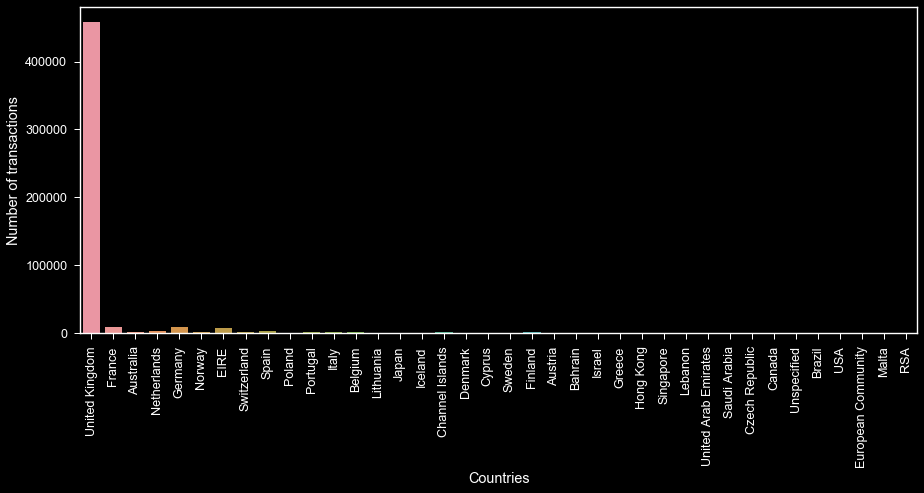

In [18]:
plt.figure(figsize=(15,6))
sns.countplot(df.Country)
plt.xlabel('Countries')
plt.ylabel('Number of transactions')
plt.xticks(rotation=90)
plt.show()

Majority of transactions are done by UK customers so believe the retail store is in UK

### Number of transactions per month

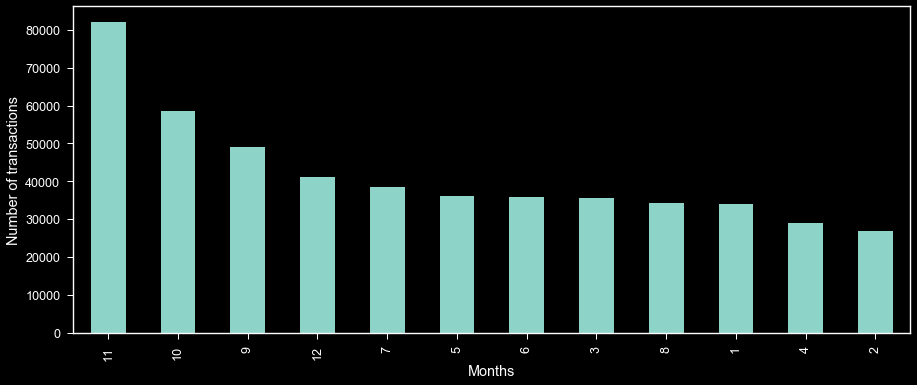

In [19]:
df.Month.value_counts().plot('bar',figsize=(15,6))
plt.xlabel('Months')
plt.ylabel('Number of transactions')
plt.show()

We can clearly see here the number of transactions is highest during the Nov month. This can be attributed to upcoming festivals in December like Christmas, New Year.

### Day wise Transactions


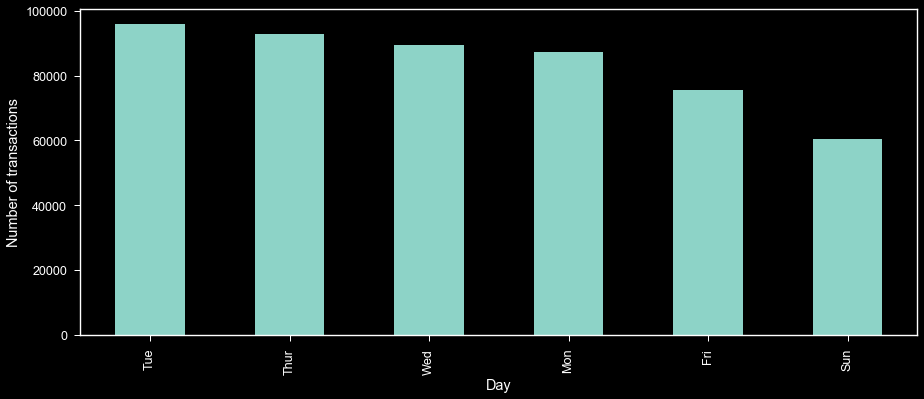

In [20]:
ax=df.Day.value_counts().plot('bar',figsize=(15,6))
ax.set_xlabel('Day')
ax.set_ylabel('Number of transactions')
ax.set_xticklabels(['Tue','Thur','Wed','Mon','Fri','Sun'])
plt.show()

Tuesday & Thursday are busiest days. Store seems to be shut for orders on Saturday

### Hour Wise Transactions

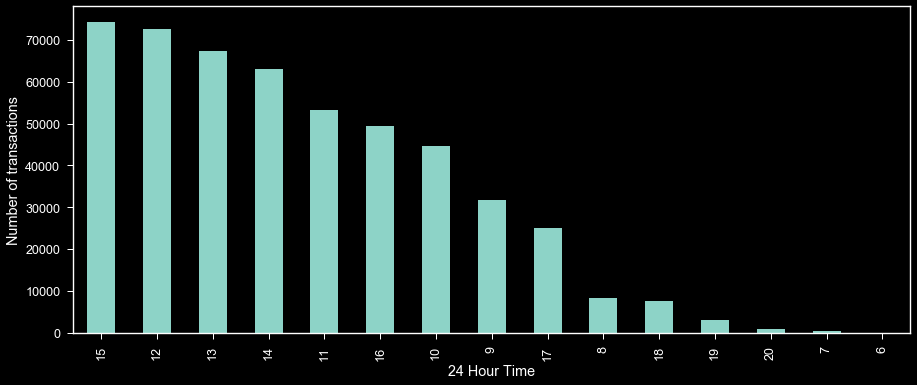

In [21]:
df.Hour.value_counts().plot('bar',figsize=(15,6))
plt.xlabel('24 Hour Time')
plt.ylabel('Number of transactions')
plt.show()

The store receives most of the orders in afternoon around 15 hours

### Top Customers by sales

### Creating New feature Amount = UnitPrice * Quantity

In [15]:
df['Amount']=df['Quantity']*df['UnitPrice']

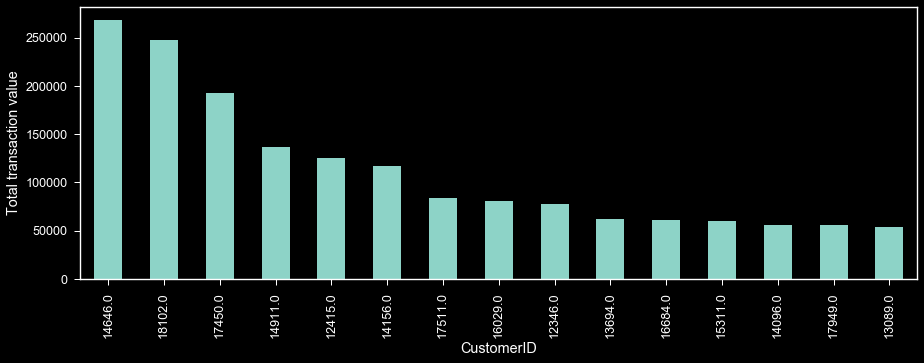

In [22]:
df.groupby('CustomerID')['Amount'].sum().sort_values(ascending=False).head(15).plot('bar',figsize=(15,5))
plt.ylabel('Total transaction value')
plt.show()

Customer with ID 14646 can be considered premium customer for the retail shop and be offered different schemes for retention

### Missing Value imputation for Description

Approach : Each Stockcode has multiple entries so some of these entries have description so we will use descriptions to fill stockcode with missing description

In [84]:
#finding unique stockcode with missing description
Miss_desc_code=np.array(df[df.Description.isnull()]['StockCode'].unique())
print(f'no of unique stockcode with blank description {len(Miss_desc_code)}')


no of unique stockcode with blank description 418


In [85]:
#Finding stockcode where description is available
df_mod=df[(~df.Description.isnull()) & (df.StockCode.isin(Miss_desc_code) )][['StockCode','Description']].drop_duplicates(subset='StockCode')
df_mod.rename(columns={'Description':'Desc'},inplace=True)
df_mod.head(3)

,StockCode,Desc
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
8,22632,HAND WARMER RED POLKA DOT


In [86]:
# merging the original and new dataframe and filling the description with new column 'desc'
df=df.merge(df_mod,on='StockCode',how='left')
df['Description'].fillna(df['Desc'],inplace=True)
df.drop(columns=['Desc'],inplace=True)

In [87]:
df.Description.isnull().sum()
# Here we are left with 16 descriptions as the corresponding stockcode have all entries as nan. So we can impute them 
#with mode or anything as this won't make much impact 

16

### Missing value imputation for CustomerID

This column is not relevant as per the problem statement and there is no logic to impute it as well so we drop it

In [88]:
df.drop(columns='CustomerID',inplace=True)

### Month wise amount for each stockcode

In [91]:
#Calculating Qty of each product in each month
df_final=pd.DataFrame(df.groupby(['Month','StockCode'])['Amount'].sum().reset_index(name='Total_Amount'))
df_final.sort_values(by=['Month','Total_Amount'],ascending=False,inplace=True)
df_final.head(5)

,Month,StockCode,Total_Amount
30106,12,22423,27694.76
31695,12,DOT,24671.19
31689,12,AMAZONFEE,13541.33
31332,12,85123A,10435.36
30946,12,84029E,9291.73


In [92]:
#Making 3 different categories (0-1000,1000-3000,>3000)as per total amount of revenue generated by each product
#in each month and creating separate column for it. These threshold for categories  can be changed as per the business.
bins=[0,1000,3000,np.inf]
labels=[3,2,1]
df_final['Priority']=pd.cut(df_final.Total_Amount,bins=bins,labels=labels)

In [93]:
df_final.to_csv('final.csv')

### Analysis

The retail store owner can check priority wise items in each month and can make a decision how the inventory should be
for the following months based on this analysis. Priority '1' items are the ones which have the highest amount generated
& priority '3' items have low total amount so the owner can look for them in each month and make the decision accordingly